In [139]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error as msle
import lightgbm as lgb
import pycaret
from pycaret.regression import *
import optuna
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
optuna.logging.set_verbosity(optuna.logging.WARNING)

In [140]:
def rmsle(y_true, y_pred):
    
    msle = msle(y_true, y_pred)

    return np.sqrt(msle)

### Make datasets

In [141]:
df1 = pd.read_csv('train_features_added.csv').drop(['month','day','hour','day_of_year'], axis=1)
df2 = pd.read_csv('UCI_preprocessed.csv').drop(['month','day','hour','day_of_year'], axis=1)
df_test = pd.read_csv('test_features_added.csv').drop(['month','day','hour','day_of_year'], axis=1)

df = pd.concat([df1, df2], axis=0)
df.reset_index(drop=True)

df_scaler = df1.copy()
df_test_scaler = df_test.copy()

df_scaler_train, df_scaler_val = train_test_split(df_scaler, test_size=0.6, shuffle=False)

def format_date_time(df):

    df['date_time'] = pd.to_datetime(df['date_time'], format='%Y-%m-%d %H:%M:%S')

    return df


df_scaler = format_date_time(df_scaler)
df_scaler_train = format_date_time(df_scaler_train)
df_scaler_val = format_date_time(df_scaler_val)
df_test_scaler = format_date_time(df_test_scaler)

df.set_index('date_time', inplace=True)
df_test.set_index('date_time', inplace=True)

In [142]:
targets = ['target_carbon_monoxide', 'target_benzene', 'target_nitrogen_oxides']

def log_trans(df, features: 'list'):

    for i in features:

        df[i] = np.log1p(df[i])

    return df

df = log_trans(df, targets)

In [143]:
df_train, df_val = train_test_split(df, test_size=0.1, shuffle=False)
df_train1, df_train2 = train_test_split(df_train, test_size=0.6, shuffle=True)

df_train2_base = df_train2.drop(targets, axis=1)

categorical_features = ['day_of_week', 'weekend', 'working_hours']

### CO

##### Compare models

In [144]:
exp_CO = setup(df_train1, target=targets[0], train_size=0.8, data_split_shuffle=True, fold_shuffle=True, use_gpu=False, ignore_features=[targets[1], targets[2]], categorical_features=categorical_features, session_id=123)

,Description,Value
0,Session id,123
1,Target,target_carbon_monoxide
2,Target type,Regression
3,Original data shape,"(5792, 24)"
4,Transformed data shape,"(5792, 28)"
5,Transformed train set shape,"(4633, 28)"
6,Transformed test set shape,"(1159, 28)"
7,Ignore features,2
8,Ordinal features,2
9,Numeric features,18


In [145]:
models = compare_models(sort='RMSLE')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,0.0566,0.0062,0.0788,0.9667,0.0409,0.0735,0.5960
lightgbm,Light Gradient Boosting Machine,0.0622,0.0075,0.0864,0.9600,0.0452,0.0824,0.2510
xgboost,Extreme Gradient Boosting,0.0644,0.0081,0.0899,0.9567,0.0462,0.0827,0.0590
et,Extra Trees Regressor,0.0640,0.0084,0.0913,0.9552,0.0474,0.0839,0.2450
rf,Random Forest Regressor,0.0707,0.0101,0.1003,0.9461,0.0521,0.0939,0.4850
gbr,Gradient Boosting Regressor,0.0738,0.0107,0.1032,0.9429,0.0543,0.1003,0.2770
knn,K Neighbors Regressor,0.0936,0.0173,0.1312,0.9076,0.0682,0.1239,0.0200
br,Bayesian Ridge,0.0963,0.0187,0.1365,0.8997,0.0711,0.1328,0.0140
ridge,Ridge Regression,0.0963,0.0187,0.1365,0.8998,0.0712,0.1328,0.0130
lr,Linear Regression,0.0964,0.0187,0.1365,0.8998,0.0712,0.1329,0.2080


##### Make base models

In [146]:
CO_catboost = create_model('catboost')
CO_xgboost = create_model('xgboost')
CO_lightgbm = create_model('lightgbm')
CO_extratrees= create_model('et')
CO_randomforest = create_model('rf')
CO_gradientboost = create_model('gbr')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0663,0.0101,0.1007,0.9448,0.0497,0.0862
1,0.0620,0.0069,0.0833,0.9627,0.0417,0.0689
2,0.0643,0.0081,0.0902,0.9523,0.0486,0.0861
3,0.0586,0.0064,0.0800,0.9634,0.0425,0.0778
4,0.0614,0.0068,0.0827,0.9645,0.0434,0.0765
5,0.0660,0.0085,0.0921,0.9587,0.0461,0.0853
6,0.0648,0.0079,0.0888,0.9562,0.0469,0.0916
7,0.0679,0.0090,0.0948,0.9535,0.0481,0.0893
8,0.0683,0.0094,0.0967,0.9529,0.0480,0.0792


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0641,0.0088,0.0937,0.9523,0.0483,0.0877
1,0.0620,0.0069,0.0830,0.9630,0.0423,0.0710
2,0.0608,0.0074,0.0861,0.9566,0.0468,0.0822
3,0.0584,0.0065,0.0807,0.9628,0.0431,0.0783
4,0.0588,0.0063,0.0795,0.9672,0.0415,0.0730
5,0.0628,0.0077,0.0878,0.9624,0.0446,0.0839
6,0.0608,0.0070,0.0838,0.9610,0.0460,0.0912
7,0.0681,0.0085,0.0923,0.9559,0.0483,0.0942
8,0.0628,0.0078,0.0883,0.9607,0.0436,0.0741


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0702,0.0101,0.1006,0.9450,0.0530,0.0965
1,0.0584,0.0063,0.0796,0.9659,0.0390,0.0637
2,0.0624,0.0083,0.0910,0.9515,0.0492,0.0859
3,0.0610,0.0072,0.0851,0.9587,0.0439,0.0776
4,0.0625,0.0080,0.0892,0.9587,0.0479,0.0806
5,0.0619,0.0081,0.0900,0.9606,0.0455,0.0823
6,0.0637,0.0079,0.0889,0.9561,0.0485,0.0953
7,0.0699,0.0099,0.0997,0.9485,0.0514,0.0967
8,0.0661,0.0106,0.1028,0.9468,0.0493,0.0765


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0742,0.0123,0.1108,0.9332,0.0573,0.1033
1,0.0682,0.0085,0.0924,0.9541,0.0466,0.0767
2,0.0660,0.0089,0.0941,0.9481,0.0496,0.0866
3,0.0658,0.0091,0.0954,0.9480,0.0499,0.0871
4,0.0691,0.0093,0.0966,0.9515,0.0514,0.0882
5,0.0731,0.0106,0.1029,0.9485,0.0526,0.0983
6,0.0691,0.0102,0.1010,0.9434,0.0543,0.1058
7,0.0779,0.0123,0.1109,0.9363,0.0579,0.1126
8,0.0727,0.0104,0.1018,0.9478,0.0498,0.0858


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0764,0.0126,0.1122,0.9315,0.0586,0.1085
1,0.0711,0.0089,0.0943,0.9522,0.0479,0.0826
2,0.0746,0.0110,0.1047,0.9358,0.0561,0.0986
3,0.0701,0.0098,0.0989,0.9441,0.0525,0.0957
4,0.0712,0.0093,0.0964,0.9518,0.0513,0.0915
5,0.0742,0.0111,0.1055,0.9458,0.0546,0.1025
6,0.0735,0.0105,0.1024,0.9418,0.0564,0.1146
7,0.0826,0.0128,0.1131,0.9338,0.0597,0.1183
8,0.0712,0.0100,0.0998,0.9498,0.0497,0.0859


In [147]:
CO_catboost = finalize_model(CO_catboost)
CO_xgboost = finalize_model(CO_xgboost)
CO_lightgbm = finalize_model(CO_lightgbm)
CO_extratrees= finalize_model(CO_extratrees)
CO_randomforest = finalize_model(CO_randomforest)
CO_gradientboost = finalize_model(CO_gradientboost)

##### Make train data for metamodel

In [148]:
predict_CO_catboost = predict_model(CO_catboost, data=df_train2_base).prediction_label.tolist()
predict_CO_xgboost = predict_model(CO_xgboost, data=df_train2_base).prediction_label.tolist()
predict_CO_lightgbm = predict_model(CO_lightgbm, data=df_train2_base).prediction_label.tolist()
predict_CO_extratrees = predict_model(CO_extratrees, data=df_train2_base).prediction_label.tolist()
predict_CO_randomforest = predict_model(CO_randomforest, data=df_train2_base).prediction_label.tolist()
predict_CO_gradientboost = predict_model(CO_gradientboost, data=df_train2_base).prediction_label.tolist()

target_carbon_monoxide = df_train2.target_carbon_monoxide.tolist()

data = {'cb':predict_CO_catboost, 'xgb':predict_CO_xgboost, 'lgbm':predict_CO_lightgbm, 'et':predict_CO_extratrees, 'rf':predict_CO_randomforest, 'gbr':predict_CO_gradientboost, 'target_carbon_monoxide':target_carbon_monoxide}
CO_meta_df = pd.DataFrame(data)


##### Make metamodel

In [149]:
CO_meta_train, CO_meta_val = train_test_split(CO_meta_df, test_size=0.2, shuffle=False)

CO_meta_train_y = CO_meta_train[targets[0]]
CO_meta_train_x = CO_meta_train.drop(targets[0], axis=1)
CO_meta_val_y = CO_meta_val[targets[0]]
CO_meta_val_x = CO_meta_val.drop(targets[0], axis=1)

In [150]:
# OptunaによるlightGBMの最適パラメータ探索
def objective(trial):

    lgb_trains = lgb.Dataset(CO_meta_train_x, CO_meta_train_y)
    lgb_valids = lgb.Dataset(CO_meta_val_x, CO_meta_val_y)
    
    learning_rate = trial.suggest_float('learning_rate', 0.0, 1.0)
    num_leaves =  trial.suggest_int('num_leaves', 2, 100)
    tree_learner = trial.suggest_categorical('tree_learner', ['serial', 'feature', 'data', 'voting'])
    lambda_l1= trial.suggest_float('lambda_l1', 0.0, 200.0)
    lambda_l2 = trial.suggest_float('lambda_l2', 0.0, 200.0)
    max_depth = trial.suggest_int('max_depth', 2, 12)
    num_iterations = trial.suggest_int('num_iterations', 10, 100)

    lgb_params = {
        'objective': 'regression',
        'boosting_type': 'gbdt', 
        'metrics': 'rmsle', 
        'learning_rate': learning_rate, 
        'num_leaves': num_leaves, 
        'tree_learner': tree_learner,
        'lambda_l1': lambda_l1, 
        'lambda_l2': lambda_l2, 
        'seed': 123, 
        'max_depth': max_depth,
        'num_iterations': num_iterations,
        'verbose': '-1'      
    }

    regressor = lgb.train(params=lgb_params,
                        train_set=lgb_trains,
                        valid_sets=lgb_valids, 
                        )

    lgb_pred = regressor.predict(CO_meta_val_x)

    rmsle = np.sqrt(msle(np.expm1(CO_meta_val_y), np.expm1(lgb_pred).clip(min=0)))
    
    return rmsle

study_CO = optuna.create_study(direction='minimize')
study_CO.optimize(objective, timeout=600)

In [151]:
CO_meta_df_y = CO_meta_df[targets[0]]
CO_meta_df_x = CO_meta_df.drop(targets[0], axis=1)

# Oputunaで求めたパラメーターを使い、COの値を予測
trains = lgb.Dataset(CO_meta_df_x, CO_meta_df_y)

meta_model_CO = lgb.train(study_CO.best_trial.params, 
                    train_set=trains,)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000930 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 8688, number of used features: 6
[LightGBM] [Info] Start training from score 1.033487
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

In [152]:
df_val_x = df_val.drop(targets[0], axis=1)
df_val_y = df_val[targets[0]]

val_predict_CO_catboost = predict_model(CO_catboost, data=df_val_x).prediction_label.tolist()
val_predict_CO_xgboost = predict_model(CO_xgboost, data=df_val_x).prediction_label.tolist()
val_predict_CO_lightgbm = predict_model(CO_lightgbm, data=df_val_x).prediction_label.tolist()
val_predict_CO_extratrees = predict_model(CO_extratrees, data=df_val_x).prediction_label.tolist()
val_predict_CO_randomforest = predict_model(CO_randomforest, data=df_val_x).prediction_label.tolist()
val_predict_CO_gradientboost = predict_model(CO_gradientboost, data=df_val_x).prediction_label.tolist()

data = {'cb':val_predict_CO_catboost, 'xgb':val_predict_CO_xgboost, 'lgbm':val_predict_CO_lightgbm, 'et':val_predict_CO_extratrees, 'rf':val_predict_CO_randomforest, 'gbr':val_predict_CO_gradientboost}
CO_meta_df_val = pd.DataFrame(data)

In [153]:
pred_CO_val = meta_model_CO.predict(CO_meta_df_val).clip(min=0)
df_val_y = df_val_y.to_numpy()
rmsle = np.sqrt(msle(np.expm1(df_val_y), np.expm1(pred_CO_val)))

rmsle

0.17657350988707238

In [154]:
test_predict_CO_catboost = predict_model(CO_catboost, data=df_test).prediction_label.tolist()
test_predict_CO_xgboost = predict_model(CO_xgboost, data=df_test).prediction_label.tolist()
test_predict_CO_lightgbm = predict_model(CO_lightgbm, data=df_test).prediction_label.tolist()
test_predict_CO_extratrees = predict_model(CO_extratrees, data=df_test).prediction_label.tolist()
test_predict_CO_randomforest = predict_model(CO_randomforest, data=df_test).prediction_label.tolist()
test_predict_CO_gradientboost = predict_model(CO_gradientboost, data=df_test).prediction_label.tolist()

data = {'cb':test_predict_CO_catboost, 'xgb':test_predict_CO_xgboost, 'lgbm':test_predict_CO_lightgbm, 'et':test_predict_CO_extratrees, 'rf':test_predict_CO_randomforest, 'gbr':test_predict_CO_gradientboost}
CO_meta_df_test = pd.DataFrame(data)

In [155]:
pred_CO_test = np.expm1(meta_model_CO.predict(CO_meta_df_test).clip(min=0))

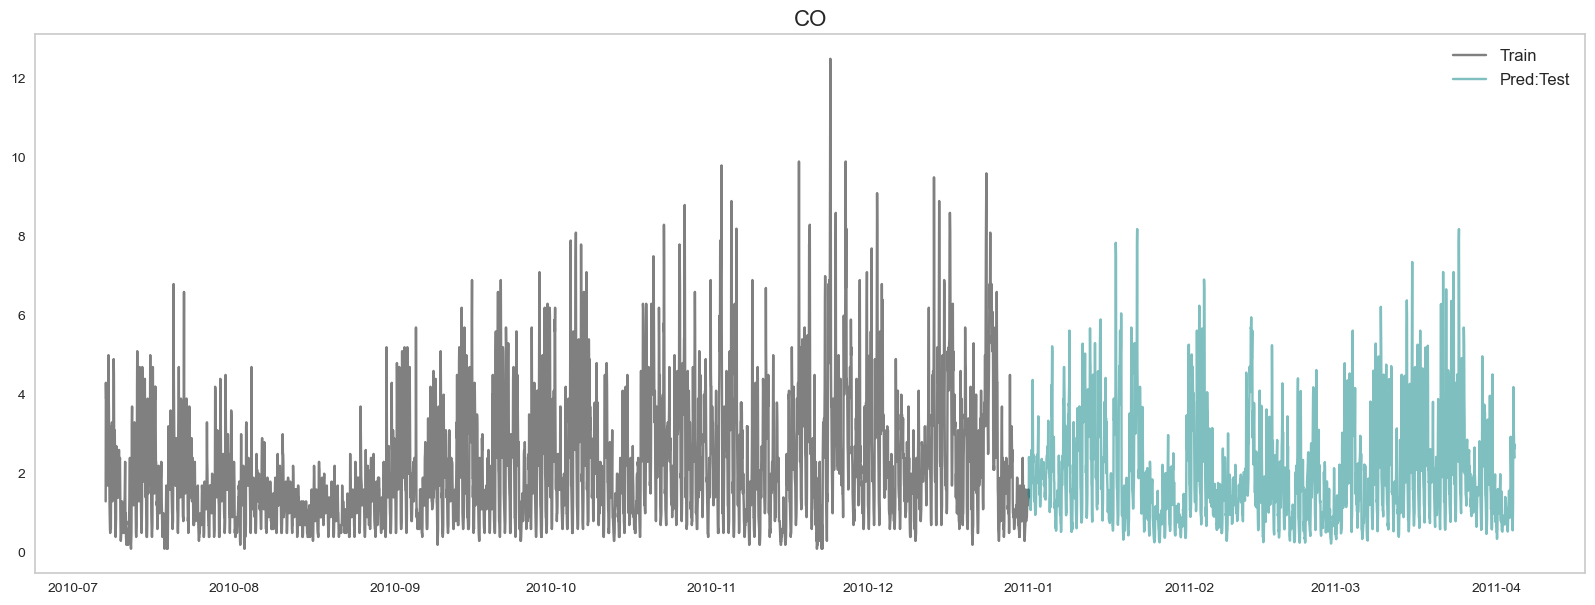

In [156]:
colors = ['teal', 'palevioletred', 'coral']
target_names = ['CO', 'C6H6', 'NOx']

fig, axs = plt.subplots(figsize=(20, 7), ncols=1, nrows=1)
plt.subplots_adjust(hspace = 0.5)

for i in range(1):

    name1 = f'pred_{target_names[i]}'
    name2 = f'val_lgb_{target_names[i]}'
    name3 = f'rmsle_{target_names[i]}'

    axs.plot(df_scaler_val['date_time'], df_scaler_val[targets[i]], color='gray', label='Train')
    #axs.plot(df_scaler_val['date_time'], np.expm1(pred_CO_val), color='yellow', alpha=0.3, label=f'Pred:Val (RMSLE:{rmsle})')
    axs.plot(df_test_scaler['date_time'], pred_CO_test, color=colors[i], alpha=0.5, label='Pred:Test')
    axs.set_title(f'{target_names[i]}', fontsize=16)
    axs.grid(axis='both')
    axs.legend(loc='upper right', fontsize=12)

plt.show()

### C6H6

In [157]:
exp_C6H6 = setup(df, target=targets[1], train_size=0.8, data_split_shuffle=True, fold_shuffle=True, use_gpu=False, ignore_features=[targets[0], targets[2]], categorical_features=categorical_features, session_id=123)


,Description,Value
0,Session id,123
1,Target,target_benzene
2,Target type,Regression
3,Original data shape,"(16089, 24)"
4,Transformed data shape,"(16089, 28)"
5,Transformed train set shape,"(12871, 28)"
6,Transformed test set shape,"(3218, 28)"
7,Ignore features,2
8,Ordinal features,2
9,Numeric features,18


In [158]:
models = compare_models(sort='RMSLE')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,0.0408,0.0035,0.0590,0.9933,0.0207,0.0242,0.7920
xgboost,Extreme Gradient Boosting,0.0435,0.0039,0.0623,0.9925,0.0219,0.0247,0.0770
lightgbm,Light Gradient Boosting Machine,0.0422,0.0039,0.0628,0.9924,0.0219,0.0240,0.2820
et,Extra Trees Regressor,0.0437,0.0042,0.0648,0.9919,0.0223,0.0233,0.6890
rf,Random Forest Regressor,0.0442,0.0044,0.0661,0.9916,0.0228,0.0238,1.5500
gbr,Gradient Boosting Regressor,0.0433,0.0044,0.0661,0.9916,0.0229,0.0249,0.6970
knn,K Neighbors Regressor,0.0601,0.0065,0.0805,0.9875,0.0288,0.0335,0.0330
ada,AdaBoost Regressor,0.0511,0.0055,0.0744,0.9894,0.0298,0.0506,0.3240
dt,Decision Tree Regressor,0.0623,0.0084,0.0915,0.9839,0.0315,0.0329,0.0560
lr,Linear Regression,0.0971,0.0169,0.1301,0.9675,0.0492,0.0763,0.1870


In [159]:
C6H6_catboost = create_model('catboost')
C6H6_xgboost = create_model('xgboost')
C6H6_lightgbm = create_model('lightgbm')
C6H6_extratrees= create_model('et')
C6H6_randomforest = create_model('rf')
C6H6_gradientboost = create_model('gbr')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0417,0.0036,0.0601,0.9929,0.0203,0.0240
1,0.0415,0.0036,0.0597,0.9935,0.0211,0.0256
2,0.0384,0.0031,0.0555,0.9944,0.0196,0.0225
3,0.0409,0.0035,0.0592,0.9928,0.0208,0.0229
4,0.0392,0.0031,0.0559,0.9940,0.0198,0.0254
5,0.0398,0.0035,0.0588,0.9939,0.0206,0.0235
6,0.0414,0.0036,0.0601,0.9927,0.0215,0.0236
7,0.0414,0.0036,0.0599,0.9930,0.0207,0.0239
8,0.0419,0.0036,0.0602,0.9931,0.0213,0.0247


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0445,0.0040,0.0632,0.9921,0.0215,0.0245
1,0.0440,0.0039,0.0626,0.9929,0.0219,0.0252
2,0.0410,0.0035,0.0589,0.9937,0.0211,0.0237
3,0.0446,0.0040,0.0634,0.9917,0.0224,0.0248
4,0.0410,0.0035,0.0590,0.9934,0.0204,0.0229
5,0.0440,0.0040,0.0631,0.9930,0.0220,0.0247
6,0.0442,0.0040,0.0634,0.9918,0.0229,0.0255
7,0.0429,0.0038,0.0614,0.9926,0.0212,0.0238
8,0.0441,0.0040,0.0631,0.9924,0.0221,0.0254


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0433,0.0041,0.0640,0.9919,0.0216,0.0239
1,0.0436,0.0041,0.0641,0.9925,0.0224,0.0251
2,0.0401,0.0036,0.0600,0.9934,0.0211,0.0228
3,0.0427,0.0040,0.0632,0.9918,0.0221,0.0235
4,0.0400,0.0036,0.0602,0.9931,0.0211,0.0235
5,0.0414,0.0039,0.0624,0.9932,0.0217,0.0242
6,0.0416,0.0039,0.0623,0.9921,0.0223,0.0239
7,0.0424,0.0040,0.0631,0.9922,0.0217,0.0234
8,0.0438,0.0042,0.0646,0.9921,0.0226,0.0254


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0451,0.0044,0.0664,0.9913,0.0224,0.0235
1,0.0437,0.0043,0.0652,0.9922,0.0225,0.0230
2,0.0411,0.0037,0.0609,0.9932,0.0210,0.0222
3,0.0442,0.0043,0.0659,0.9911,0.0229,0.0239
4,0.0416,0.0038,0.0618,0.9927,0.0209,0.0220
5,0.0429,0.0041,0.0641,0.9928,0.0222,0.0229
6,0.0448,0.0043,0.0653,0.9913,0.0228,0.0247
7,0.0439,0.0042,0.0647,0.9918,0.0221,0.0232
8,0.0461,0.0045,0.0671,0.9914,0.0233,0.0249


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0456,0.0045,0.0670,0.9911,0.0226,0.0237
1,0.0442,0.0045,0.0669,0.9918,0.0231,0.0232
2,0.0422,0.0039,0.0623,0.9929,0.0214,0.0225
3,0.0454,0.0046,0.0676,0.9906,0.0234,0.0242
4,0.0415,0.0040,0.0629,0.9925,0.0212,0.0219
5,0.0432,0.0043,0.0654,0.9925,0.0232,0.0249
6,0.0448,0.0044,0.0665,0.9910,0.0235,0.0245
7,0.0444,0.0044,0.0660,0.9915,0.0227,0.0233
8,0.0465,0.0047,0.0686,0.9910,0.0238,0.0252


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0446,0.0044,0.0666,0.9912,0.0226,0.0250
1,0.0450,0.0046,0.0679,0.9916,0.0237,0.0264
2,0.0407,0.0039,0.0624,0.9929,0.0216,0.0235
3,0.0444,0.0045,0.0672,0.9907,0.0233,0.0246
4,0.0405,0.0040,0.0633,0.9924,0.0215,0.0232
5,0.0424,0.0043,0.0656,0.9924,0.0232,0.0258
6,0.0436,0.0044,0.0664,0.9910,0.0236,0.0252
7,0.0435,0.0044,0.0662,0.9914,0.0229,0.0242
8,0.0459,0.0047,0.0687,0.9910,0.0239,0.0269


In [160]:
C6H6_catboost = finalize_model(C6H6_catboost)
C6H6_xgboost = finalize_model(C6H6_xgboost)
C6H6_lightgbm = finalize_model(C6H6_lightgbm)
C6H6_extratrees= finalize_model(C6H6_extratrees)
C6H6_randomforest = finalize_model(C6H6_randomforest)
C6H6_gradientboost = finalize_model(C6H6_gradientboost)

In [161]:
predict_C6H6_catboost = predict_model(C6H6_catboost, data=df_train2_base).prediction_label.tolist()
predict_C6H6_xgboost = predict_model(C6H6_xgboost, data=df_train2_base).prediction_label.tolist()
predict_C6H6_lightgbm = predict_model(C6H6_lightgbm, data=df_train2_base).prediction_label.tolist()
predict_C6H6_extratrees = predict_model(C6H6_extratrees, data=df_train2_base).prediction_label.tolist()
predict_C6H6_randomforest = predict_model(C6H6_randomforest, data=df_train2_base).prediction_label.tolist()
predict_C6H6_gradientboost = predict_model(C6H6_gradientboost, data=df_train2_base).prediction_label.tolist()

target_benzene = df_train2.target_benzene.tolist()

data = {'cb':predict_C6H6_catboost, 'xgb':predict_C6H6_xgboost, 'lgbm':predict_C6H6_lightgbm, 'et':predict_C6H6_extratrees, 'rf':predict_C6H6_randomforest, 'gbr':predict_C6H6_gradientboost, 'target_benzene':target_benzene}
C6H6_meta_df = pd.DataFrame(data)

In [162]:
C6H6_meta_train, C6H6_meta_val = train_test_split(C6H6_meta_df, test_size=0.2, shuffle=False)

C6H6_meta_train_y = C6H6_meta_train[targets[1]]
C6H6_meta_train_x = C6H6_meta_train.drop(targets[1], axis=1)
C6H6_meta_val_y = C6H6_meta_val[targets[1]]
C6H6_meta_val_x = C6H6_meta_val.drop(targets[1], axis=1)

In [163]:
# OptunaによるlightGBMの最適パラメータ探索
def objective(trial):

    lgb_trains = lgb.Dataset(C6H6_meta_train_x, C6H6_meta_train_y)
    lgb_valids = lgb.Dataset(C6H6_meta_val_x, C6H6_meta_val_y)
    
    learning_rate = trial.suggest_float('learning_rate', 0.0, 1.0)
    num_leaves =  trial.suggest_int('num_leaves', 2, 100)
    tree_learner = trial.suggest_categorical('tree_learner', ['serial', 'feature', 'data', 'voting'])
    lambda_l1= trial.suggest_float('lambda_l1', 0.0, 200.0)
    lambda_l2 = trial.suggest_float('lambda_l2', 0.0, 200.0)
    max_depth = trial.suggest_int('max_depth', 2, 12)
    num_iterations = trial.suggest_int('num_iterations', 10, 100)

    lgb_params = {
        'objective': 'regression',
        'boosting_type': 'gbdt', 
        'metrics': 'rmsle', 
        'learning_rate': learning_rate, 
        'num_leaves': num_leaves, 
        'tree_learner': tree_learner,
        'lambda_l1': lambda_l1, 
        'lambda_l2': lambda_l2, 
        'seed': 123, 
        'max_depth': max_depth,
        'num_iterations': num_iterations,
        'verbose': '-1'      
    }

    regressor = lgb.train(params=lgb_params,
                        train_set=lgb_trains,
                        valid_sets=lgb_valids, 
                        )

    lgb_pred = regressor.predict(C6H6_meta_val_x)

    rmsle = np.sqrt(msle(np.expm1(C6H6_meta_val_y), np.expm1(lgb_pred).clip(min=0)))
    
    return rmsle

study_C6H6 = optuna.create_study(direction='minimize')
study_C6H6.optimize(objective, timeout=600)

In [164]:
C6H6_meta_df_y = C6H6_meta_df[targets[1]]
C6H6_meta_df_x = C6H6_meta_df.drop(targets[1], axis=1)

# Oputunaで求めたパラメーターを使い、C6H6の値を予測
trains = lgb.Dataset(C6H6_meta_df_x, C6H6_meta_df_y)

meta_model_C6H6 = lgb.train(study_C6H6.best_trial.params, train_set=trains)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000238 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 8688, number of used features: 6
[LightGBM] [Info] Start training from score 2.202180
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

In [165]:
df_val_x = df_val.drop(targets[1], axis=1)
df_val_y = df_val[targets[1]]

val_predict_C6H6_catboost = predict_model(C6H6_catboost, data=df_val_x).prediction_label.tolist()
val_predict_C6H6_xgboost = predict_model(C6H6_xgboost, data=df_val_x).prediction_label.tolist()
val_predict_C6H6_lightgbm = predict_model(C6H6_lightgbm, data=df_val_x).prediction_label.tolist()
val_predict_C6H6_extratrees = predict_model(C6H6_extratrees, data=df_val_x).prediction_label.tolist()
val_predict_C6H6_randomforest = predict_model(C6H6_randomforest, data=df_val_x).prediction_label.tolist()
val_predict_C6H6_gradientboost = predict_model(C6H6_gradientboost, data=df_val_x).prediction_label.tolist()

data = {'cb':val_predict_C6H6_catboost, 'xgb':val_predict_C6H6_xgboost, 'lgbm':val_predict_C6H6_lightgbm, 'et':val_predict_C6H6_extratrees, 'rf':val_predict_C6H6_randomforest, 'gbr':val_predict_C6H6_gradientboost}
C6H6_meta_df_val = pd.DataFrame(data)

In [166]:
pred_C6H6_val = meta_model_C6H6.predict(C6H6_meta_df_val).clip(min=0)
df_val_y = df_val_y.to_numpy()
rmsle = np.sqrt(msle(np.expm1(df_val_y), np.expm1(pred_C6H6_val)))

rmsle

0.008116179099932163

In [167]:
test_predict_C6H6_catboost = predict_model(C6H6_catboost, data=df_test).prediction_label.tolist()
test_predict_C6H6_xgboost = predict_model(C6H6_xgboost, data=df_test).prediction_label.tolist()
test_predict_C6H6_lightgbm = predict_model(C6H6_lightgbm, data=df_test).prediction_label.tolist()
test_predict_C6H6_extratrees = predict_model(C6H6_extratrees, data=df_test).prediction_label.tolist()
test_predict_C6H6_randomforest = predict_model(C6H6_randomforest, data=df_test).prediction_label.tolist()
test_predict_C6H6_gradientboost = predict_model(C6H6_gradientboost, data=df_test).prediction_label.tolist()

data = {'cb':test_predict_C6H6_catboost, 'xgb':test_predict_C6H6_xgboost, 'lgbm':test_predict_C6H6_lightgbm, 'et':test_predict_C6H6_extratrees, 'rf':test_predict_C6H6_randomforest, 'gbr':test_predict_C6H6_gradientboost}
C6H6_meta_df_test = pd.DataFrame(data)

In [168]:
pred_C6H6_test = np.expm1(meta_model_C6H6.predict(C6H6_meta_df_test).clip(min=0))

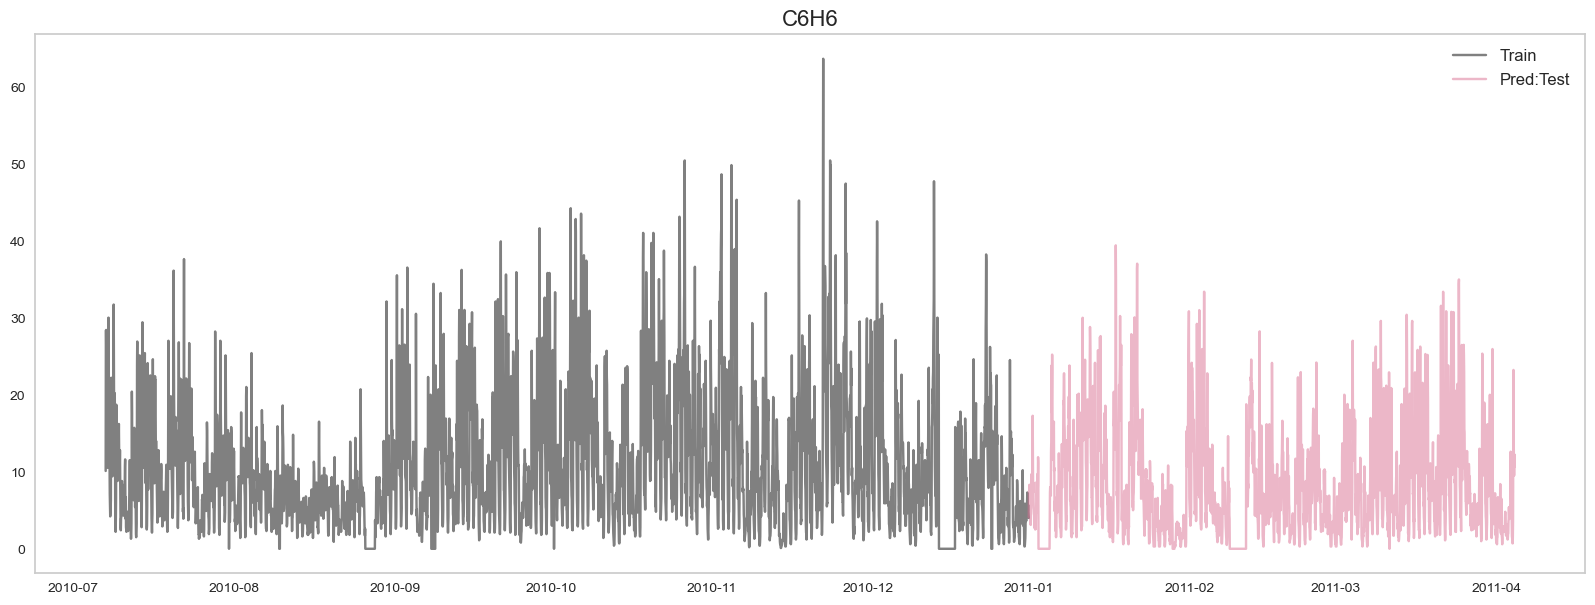

In [169]:
colors = ['teal', 'palevioletred', 'coral']
target_names = ['CO', 'C6H6', 'NOx']

fig, axs = plt.subplots(figsize=(20, 7), ncols=1, nrows=1)
plt.subplots_adjust(hspace = 0.5)

for i in range(1,2):

    axs.plot(df_scaler_val['date_time'], df_scaler_val[targets[i]], color='gray', label='Train')
    #axs.plot(df_scaler_val['date_time'], np.expm1(pred_CO_val), color='yellow', alpha=0.3, label=f'Pred:Val (RMSLE:{rmsle})')
    axs.plot(df_test_scaler['date_time'], pred_C6H6_test, color=colors[i], alpha=0.5, label='Pred:Test')
    axs.set_title(f'{target_names[i]}', fontsize=16)
    axs.grid(axis='both')
    axs.legend(loc='upper right', fontsize=12)

plt.show()

### NOx

In [170]:
exp_NOx = setup(df, target=targets[2], train_size=0.8, data_split_shuffle=True, fold_shuffle=True, use_gpu=False, ignore_features=[targets[1], targets[0]], categorical_features=categorical_features, session_id=123)

,Description,Value
0,Session id,123
1,Target,target_nitrogen_oxides
2,Target type,Regression
3,Original data shape,"(16089, 24)"
4,Transformed data shape,"(16089, 28)"
5,Transformed train set shape,"(12871, 28)"
6,Transformed test set shape,"(3218, 28)"
7,Ignore features,2
8,Ordinal features,2
9,Numeric features,18


In [171]:
models = compare_models(sort='RMSLE')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,0.1053,0.0218,0.1475,0.9718,0.0272,0.0225,0.6600
catboost,CatBoost Regressor,0.1108,0.0226,0.1502,0.9707,0.0275,0.0236,0.7280
xgboost,Extreme Gradient Boosting,0.1209,0.0265,0.1627,0.9657,0.0297,0.0257,0.0730
lightgbm,Light Gradient Boosting Machine,0.1281,0.0302,0.1736,0.9609,0.0320,0.0274,0.2490
rf,Random Forest Regressor,0.1252,0.0301,0.1734,0.9610,0.0323,0.0269,1.3740
gbr,Gradient Boosting Regressor,0.1610,0.0465,0.2155,0.9398,0.0397,0.0345,0.6700
dt,Decision Tree Regressor,0.1770,0.0655,0.2557,0.9152,0.0470,0.0377,0.0470
knn,K Neighbors Regressor,0.2104,0.0869,0.2946,0.8873,0.0527,0.0448,0.0310
ridge,Ridge Regression,0.2311,0.0966,0.3106,0.8750,0.0557,0.0493,0.0190
lr,Linear Regression,0.2312,0.0966,0.3106,0.8750,0.0557,0.0493,0.1990


In [172]:
NOx_catboost = create_model('catboost')
NOx_xgboost = create_model('xgboost')
NOx_lightgbm = create_model('lightgbm')
NOx_extratrees= create_model('et')
NOx_randomforest = create_model('rf')
NOx_gradientboost = create_model('gbr')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.1107,0.0235,0.1532,0.9695,0.0282,0.0235
1,0.1103,0.0242,0.1555,0.9684,0.0294,0.0237
2,0.1132,0.0244,0.1562,0.9693,0.0279,0.0239
3,0.1095,0.0224,0.1498,0.9704,0.0268,0.0234
4,0.1120,0.0225,0.1499,0.9683,0.0271,0.0235
5,0.1124,0.0228,0.1511,0.9733,0.0276,0.0240
6,0.1097,0.0212,0.1456,0.9719,0.0259,0.0230
7,0.1074,0.0205,0.1431,0.9735,0.0264,0.0228
8,0.1103,0.0213,0.1458,0.9725,0.0276,0.0238


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.1248,0.0287,0.1694,0.9627,0.0303,0.0262
1,0.1224,0.0287,0.1694,0.9625,0.0317,0.0263
2,0.1209,0.0269,0.1641,0.9661,0.0297,0.0256
3,0.1198,0.0255,0.1598,0.9663,0.0288,0.0257
4,0.1200,0.0263,0.1621,0.9629,0.0295,0.0253
5,0.1227,0.0266,0.1631,0.9689,0.0301,0.0263
6,0.1149,0.0230,0.1517,0.9695,0.0268,0.0240
7,0.1206,0.0267,0.1634,0.9654,0.0299,0.0256
8,0.1222,0.0269,0.1639,0.9653,0.0307,0.0263


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.1297,0.0315,0.1774,0.9591,0.0328,0.0277
1,0.1303,0.0333,0.1824,0.9566,0.0348,0.0281
2,0.1296,0.0314,0.1772,0.9605,0.0318,0.0275
3,0.1287,0.0309,0.1757,0.9593,0.0313,0.0275
4,0.1291,0.0305,0.1746,0.9570,0.0317,0.0272
5,0.1267,0.0287,0.1694,0.9664,0.0310,0.0270
6,0.1252,0.0280,0.1674,0.9629,0.0302,0.0263
7,0.1263,0.0287,0.1694,0.9628,0.0317,0.0270
8,0.1244,0.0281,0.1675,0.9637,0.0317,0.0269


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.1056,0.0226,0.1502,0.9707,0.0281,0.0225
1,0.1041,0.0239,0.1546,0.9688,0.0292,0.0224
2,0.1106,0.0246,0.1570,0.9690,0.0283,0.0234
3,0.1047,0.0216,0.1468,0.9715,0.0263,0.0223
4,0.1053,0.0204,0.1427,0.9713,0.0260,0.0222
5,0.1026,0.0204,0.1428,0.9761,0.0265,0.0220
6,0.1041,0.0210,0.1448,0.9722,0.0261,0.0219
7,0.1050,0.0206,0.1436,0.9733,0.0268,0.0224
8,0.1066,0.0219,0.1480,0.9717,0.0276,0.0229


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.1262,0.0318,0.1783,0.9588,0.0331,0.0270
1,0.1259,0.0322,0.1796,0.9579,0.0345,0.0275
2,0.1302,0.0334,0.1828,0.9580,0.0336,0.0280
3,0.1232,0.0286,0.1692,0.9622,0.0303,0.0264
4,0.1242,0.0299,0.1728,0.9579,0.0321,0.0264
5,0.1241,0.0291,0.1707,0.9659,0.0317,0.0267
6,0.1217,0.0276,0.1660,0.9635,0.0297,0.0255
7,0.1257,0.0300,0.1733,0.9611,0.0332,0.0272
8,0.1278,0.0303,0.1741,0.9608,0.0329,0.0278


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.1587,0.0463,0.2151,0.9399,0.0400,0.0340
1,0.1691,0.0528,0.2299,0.9310,0.0437,0.0366
2,0.1659,0.0504,0.2246,0.9366,0.0407,0.0353
3,0.1607,0.0470,0.2168,0.9379,0.0388,0.0344
4,0.1592,0.0446,0.2112,0.9371,0.0380,0.0334
5,0.1620,0.0449,0.2120,0.9474,0.0387,0.0346
6,0.1576,0.0429,0.2071,0.9432,0.0371,0.0330
7,0.1588,0.0451,0.2123,0.9417,0.0396,0.0339
8,0.1612,0.0463,0.2153,0.9400,0.0408,0.0351


In [173]:
NOx_catboost = finalize_model(NOx_catboost)
NOx_xgboost = finalize_model(NOx_xgboost)
NOx_lightgbm = finalize_model(NOx_lightgbm)
NOx_extratrees= finalize_model(NOx_extratrees)
NOx_randomforest = finalize_model(NOx_randomforest)
NOx_gradientboost = finalize_model(NOx_gradientboost)

In [174]:
predict_NOx_catboost = predict_model(NOx_catboost, data=df_train2_base).prediction_label.tolist()
predict_NOx_xgboost = predict_model(NOx_xgboost, data=df_train2_base).prediction_label.tolist()
predict_NOx_lightgbm = predict_model(NOx_lightgbm, data=df_train2_base).prediction_label.tolist()
predict_NOx_extratrees = predict_model(NOx_extratrees, data=df_train2_base).prediction_label.tolist()
predict_NOx_randomforest = predict_model(NOx_randomforest, data=df_train2_base).prediction_label.tolist()
predict_NOx_gradientboost = predict_model(NOx_gradientboost, data=df_train2_base).prediction_label.tolist()

target_nitrogen_oxides = df_train2.target_nitrogen_oxides.tolist()

data = {'cb':predict_NOx_catboost, 'xgb':predict_NOx_xgboost, 'lgbm':predict_NOx_lightgbm, 'et':predict_NOx_extratrees, 'rf':predict_NOx_randomforest, 'gbr':predict_NOx_gradientboost, 'target_nitrogen_oxides':target_nitrogen_oxides}
NOx_meta_df = pd.DataFrame(data)

In [175]:
NOx_meta_train, NOx_meta_val = train_test_split(NOx_meta_df, test_size=0.2, shuffle=False)

NOx_meta_train_y = NOx_meta_train[targets[2]]
NOx_meta_train_x = NOx_meta_train.drop(targets[2], axis=1)
NOx_meta_val_y = NOx_meta_val[targets[2]]
NOx_meta_val_x = NOx_meta_val.drop(targets[2], axis=1)

In [176]:
# OptunaによるlightGBMの最適パラメータ探索
def objective(trial):

    lgb_trains = lgb.Dataset(NOx_meta_train_x, NOx_meta_train_y)
    lgb_valids = lgb.Dataset(NOx_meta_val_x, NOx_meta_val_y)
    
    learning_rate = trial.suggest_float('learning_rate', 0.0, 1.0)
    num_leaves =  trial.suggest_int('num_leaves', 2, 100)
    tree_learner = trial.suggest_categorical('tree_learner', ['serial', 'feature', 'data', 'voting'])
    lambda_l1= trial.suggest_float('lambda_l1', 0.0, 200.0)
    lambda_l2 = trial.suggest_float('lambda_l2', 0.0, 200.0)
    max_depth = trial.suggest_int('max_depth', 2, 12)
    num_iterations = trial.suggest_int('num_iterations', 10, 100)

    lgb_params = {
        'objective': 'regression',
        'boosting_type': 'gbdt', 
        'metrics': 'rmsle', 
        'learning_rate': learning_rate, 
        'num_leaves': num_leaves, 
        'tree_learner': tree_learner,
        'lambda_l1': lambda_l1, 
        'lambda_l2': lambda_l2, 
        'seed': 123, 
        'max_depth': max_depth,
        'num_iterations': num_iterations,
        'verbose': '-1'      
    }

    regressor = lgb.train(params=lgb_params,
                        train_set=lgb_trains,
                        valid_sets=lgb_valids, 
                        )

    lgb_pred = regressor.predict(NOx_meta_val_x)

    rmsle = np.sqrt(msle(np.expm1(NOx_meta_val_y), np.expm1(lgb_pred).clip(min=0)))
    
    return rmsle

study_NOx = optuna.create_study(direction='minimize')
study_NOx.optimize(objective, timeout=600)

In [177]:
NOx_meta_df_y = NOx_meta_df[targets[2]]
NOx_meta_df_x = NOx_meta_df.drop(targets[2], axis=1)

# Oputunaで求めたパラメーターを使い、NOxの値を予測
trains = lgb.Dataset(NOx_meta_df_x, NOx_meta_df_y)

meta_model_NOx = lgb.train(study_NOx.best_trial.params, train_set=trains)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000304 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 8688, number of used features: 6
[LightGBM] [Info] Start training from score 4.977274
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

In [178]:
df_val_x = df_val.drop(targets[2], axis=1)
df_val_y = df_val[targets[2]]

val_predict_NOx_catboost = predict_model(NOx_catboost, data=df_val_x).prediction_label.tolist()
val_predict_NOx_xgboost = predict_model(NOx_xgboost, data=df_val_x).prediction_label.tolist()
val_predict_NOx_lightgbm = predict_model(NOx_lightgbm, data=df_val_x).prediction_label.tolist()
val_predict_NOx_extratrees = predict_model(NOx_extratrees, data=df_val_x).prediction_label.tolist()
val_predict_NOx_randomforest = predict_model(NOx_randomforest, data=df_val_x).prediction_label.tolist()
val_predict_NOx_gradientboost = predict_model(NOx_gradientboost, data=df_val_x).prediction_label.tolist()

data = {'cb':val_predict_NOx_catboost, 'xgb':val_predict_NOx_xgboost, 'lgbm':val_predict_NOx_lightgbm, 'et':val_predict_NOx_extratrees, 'rf':val_predict_NOx_randomforest, 'gbr':val_predict_NOx_gradientboost}
NOx_meta_df_val = pd.DataFrame(data)

In [179]:
pred_NOx_val = meta_model_NOx.predict(NOx_meta_df_val).clip(min=0)
df_val_y = df_val_y.to_numpy()
rmsle = np.sqrt(msle(np.expm1(df_val_y), np.expm1(pred_NOx_val)))

rmsle

0.0061820518542782844

In [180]:
test_predict_NOx_catboost = predict_model(NOx_catboost, data=df_test).prediction_label.tolist()
test_predict_NOx_xgboost = predict_model(NOx_xgboost, data=df_test).prediction_label.tolist()
test_predict_NOx_lightgbm = predict_model(NOx_lightgbm, data=df_test).prediction_label.tolist()
test_predict_NOx_extratrees = predict_model(NOx_extratrees, data=df_test).prediction_label.tolist()
test_predict_NOx_randomforest = predict_model(NOx_randomforest, data=df_test).prediction_label.tolist()
test_predict_NOx_gradientboost = predict_model(NOx_gradientboost, data=df_test).prediction_label.tolist()

data = {'cb':test_predict_NOx_catboost, 'xgb':test_predict_NOx_xgboost, 'lgbm':test_predict_NOx_lightgbm, 'et':test_predict_NOx_extratrees, 'rf':test_predict_NOx_randomforest, 'gbr':test_predict_NOx_gradientboost}
NOx_meta_df_test = pd.DataFrame(data)

In [181]:
pred_NOx_test = np.expm1(meta_model_NOx.predict(NOx_meta_df_test).clip(min=0))

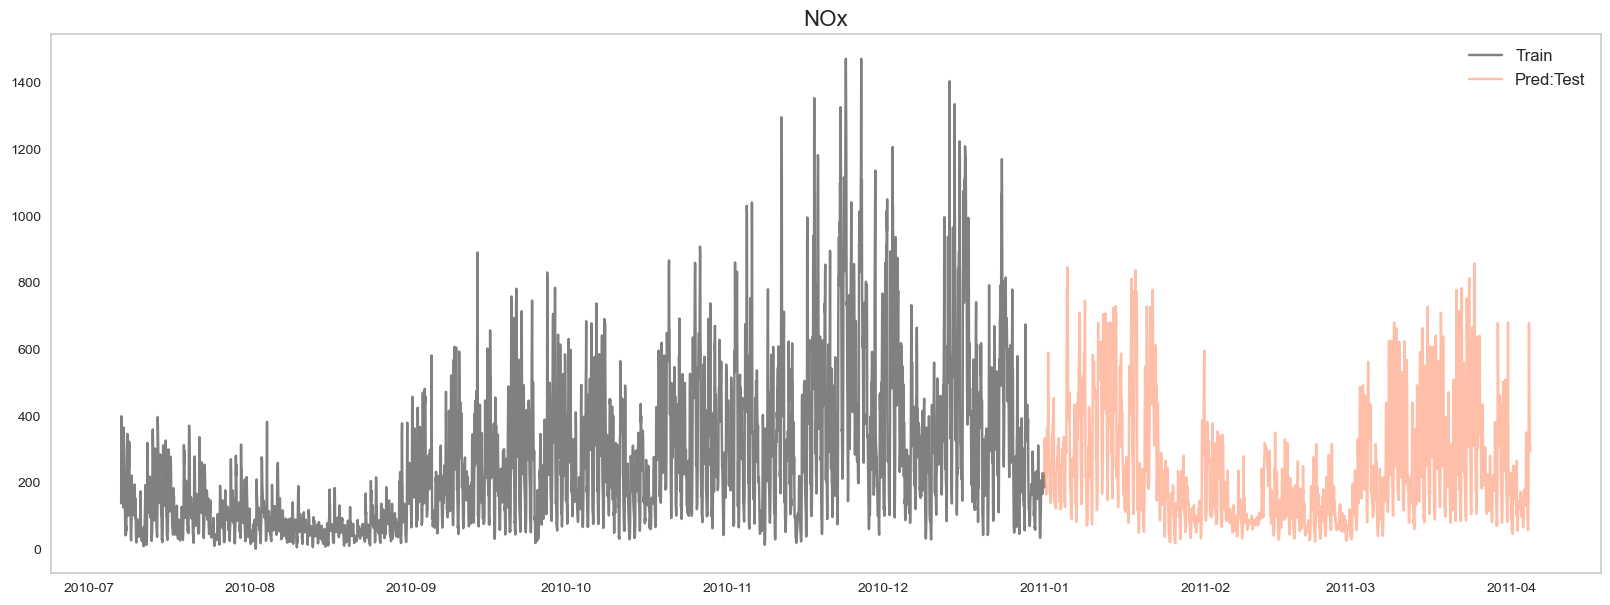

In [182]:
colors = ['teal', 'palevioletred', 'coral']
target_names = ['CO', 'C6H6', 'NOx']

fig, axs = plt.subplots(figsize=(20, 7), ncols=1, nrows=1)
plt.subplots_adjust(hspace = 0.5)

for i in range(2,3):

    axs.plot(df_scaler_val['date_time'], df_scaler_val[targets[i]], color='gray', label='Train')
    #axs.plot(df_scaler_val['date_time'], np.expm1(pred_CO_val), color='yellow', alpha=0.3, label=f'Pred:Val (RMSLE:{rmsle})')
    axs.plot(df_test_scaler['date_time'], pred_NOx_test, color=colors[i], alpha=0.5, label='Pred:Test')
    axs.set_title(f'{target_names[i]}', fontsize=16)
    axs.grid(axis='both')
    axs.legend(loc='upper right', fontsize=12)

plt.show()

In [183]:
submit_base = pd.read_csv('sample_submission.csv')

submit = pd.DataFrame()

submit['date_time'] = submit_base['date_time']
submit[targets[0]] = pred_CO_test
submit[targets[1]] = pred_C6H6_test
submit[targets[2]] = pred_NOx_test

submit.to_csv('submission_stacking.csv', index=False)

In [184]:
submit

,date_time,target_carbon_monoxide,target_benzene,target_nitrogen_oxides
0,2011-01-01 00:00:00,1.432146,4.198243,222.346354
1,2011-01-01 01:00:00,2.421488,7.599208,325.862701
2,2011-01-01 02:00:00,2.211734,7.396851,318.579308
3,2011-01-01 03:00:00,2.155026,8.406030,333.921660
4,2011-01-01 04:00:00,1.749917,6.505109,244.428157
...,...,...,...,...
2242,2011-04-04 10:00:00,3.013260,11.793132,487.419026
2243,2011-04-04 11:00:00,2.627572,9.604001,358.138356
2244,2011-04-04 12:00:00,2.745616,12.192629,338.850398
2245,2011-04-04 13:00:00,2.423598,10.700148,295.962647


Kaggle Score:<br>
train:test=5:5<br>
Private:0.23417, Public:0.27045<br>
739/1293
<br><br>
train:test=8:2<br>
Private:0.26483, Public:0.30414<br>
<br><br>
train:test=2:8<br>
Private:0.26516, Public:0.30615<br>
<br><br>
train:test=6:4<br>
Private:0.26516, Public:0.30185<br>
<br><br>
train:test=4:6<br>
Private:0.26541, Public:0.30344<br>
<br><br>
